<a href="https://colab.research.google.com/github/aditya-chawla/Biomedical-RAG-LLM/blob/main/BioMedical_RAG_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install biopython
!pip install -U sympy
!pip install sacremoses
!pip install gradio
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu121 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 74.8 MB/s eta 0:00:00
   ━━

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from Bio import Entrez
import torch
import gradio as gr
from tqdm import tqdm

# Set up NCBI Entrez
Entrez.email = "aditya.chawla@sjsu.edu"  # Replace with your email address

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load BioGPT-Large model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT-Large-PubMedQA")
model = AutoModelForCausalLM.from_pretrained("microsoft/BioGPT-Large-PubMedQA").to(device)

# Load the PubMedQA dataset (train split used for evaluation here)
dataset = load_dataset("pubmed_qa", "pqa_labeled")
train_data = dataset["train"]

# Function to fetch and summarize data from NCBI Entrez
def fetch_and_summarize(query):
    try:
        search_handle = Entrez.esearch(db="pubmed", term=query, retmax=1)
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if search_results["IdList"]:
            pubmed_id = search_results["IdList"][0]
            summary_handle = Entrez.esummary(db="pubmed", id=pubmed_id)
            summary_results = Entrez.read(summary_handle)
            summary_handle.close()
            summary = summary_results[0]["Title"]
            return summary
        else:
            return "No additional context found in PubMed."
    except Exception as e:
        return f"Error fetching data: {e}"

# Function to generate answers using BioGPT-Large
def generate_answer(question, context):
    try:
        combined_context = f"{context} {fetch_and_summarize(question)}"
        prompt = f"question: {question} context: {combined_context} the answer to the question given the context is"

        # Tokenize input for BioGPT-Large
        inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

        # Generate output
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=False  # Deterministic results
        )

        # Decode the model's output
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        return f"Error generating answer: {e}"

# Accuracy calculation for PubMedQA dataset
correct = 0
total = 0
batch_correct = 0
batch_total = 0
batch_size = 200

for i, item in enumerate(tqdm(train_data, desc="Processing data")):
    question = item["question"]
    context_list = item["context"]["contexts"]  # Extract the 'contexts' list
    context = " ".join(context_list)  # Combine all contexts into a single string
    ground_truth = item["final_decision"]  # Ground truth answer: "yes", "no", or "maybe"

    # Fetch additional context from NCBI Entrez
    additional_context = fetch_and_summarize(question)
    combined_context = f"{context} {additional_context}"

    # Format the input to BioGPT-Large for yes/no answer generation
    prompt = f"question: {question} context: {combined_context} the answer to the question given the context is"

    # Tokenize input for BioGPT-Large
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

    # Generate output with controlled length
    outputs = model.generate(
        **inputs,
        max_new_tokens=50,  # Adjust to get a short yes/no answer
        do_sample=False  # Use greedy decoding for deterministic results
    )

    # Decode the model's output
    predicted_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Compare raw model output with the ground truth
    if ground_truth.lower() in predicted_answer.lower():  # Simple matching
        correct += 1
        batch_correct += 1
    total += 1
    batch_total += 1

    # Evaluate batch accuracy
    if batch_total == batch_size:
        batch_accuracy = (batch_correct / batch_total) * 100
        print(f"Batch {i // batch_size + 1} Accuracy: {batch_accuracy:.2f}%")
        batch_correct = 0
        batch_total = 0

# Calculate final accuracy
final_accuracy = (correct / total) * 100
print(f"Final Accuracy on PubMedQA: {final_accuracy:.2f}%")



Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/566k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Processing data:  20%|██        | 200/1000 [09:16<39:28,  2.96s/it]

Batch 1 Accuracy: 71.00%


Processing data:  40%|████      | 400/1000 [18:27<27:47,  2.78s/it]

Batch 2 Accuracy: 75.00%


Processing data:  60%|██████    | 600/1000 [27:32<17:38,  2.65s/it]

Batch 3 Accuracy: 81.50%


Processing data:  80%|████████  | 800/1000 [36:28<08:30,  2.55s/it]

Batch 4 Accuracy: 81.00%


Processing data: 100%|██████████| 1000/1000 [45:30<00:00,  2.73s/it]

Batch 5 Accuracy: 81.50%
Final Accuracy on PubMedQA: 78.00%


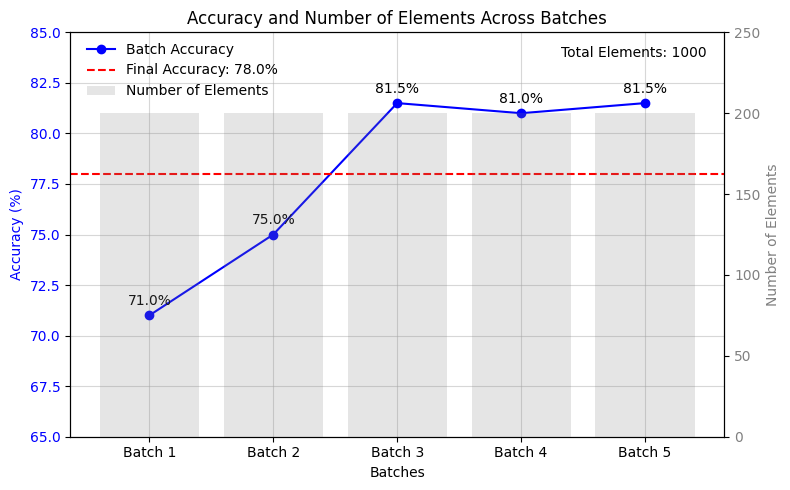

In [ ]:
import matplotlib.pyplot as plt

# Data
batches = ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5']
accuracy = [71.00, 75.00, 81.50, 81.00, 81.50]
elements = [200, 200, 200, 200, 200]  # Number of elements in each batch
final_accuracy = 78.00
total_elements = sum(elements)

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary axis for accuracy
ax1.plot(batches, accuracy, marker='o', label='Batch Accuracy', color='blue')
ax1.axhline(y=final_accuracy, color='red', linestyle='--', label=f'Final Accuracy: {final_accuracy:.1f}%')
ax1.set_ylabel("Accuracy (%)", color='blue')
ax1.set_ylim(65, 85)
ax1.set_xlabel("Batches")
ax1.grid(alpha=0.5)
ax1.tick_params(axis='y', labelcolor='blue')

# Annotations for accuracy
for i, (acc, elem) in enumerate(zip(accuracy, elements)):
    ax1.text(i, acc + 0.5, f"{acc:.1f}%", ha='center', fontsize=10)

# Secondary axis for number of elements
ax2 = ax1.twinx()
ax2.bar(batches, elements, alpha=0.2, color='gray', label='Number of Elements')
ax2.set_ylabel("Number of Elements", color='gray')
ax2.set_ylim(0, max(elements) + 50)
ax2.tick_params(axis='y', labelcolor='gray')

# Total elements annotation
plt.text(len(batches) - 0.5, max(elements) + 35,
         f"Total Elements: {total_elements}",
         ha='right', fontsize=10, color='black')

# Legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.93), frameon=False, fontsize=10)

# Title and layout
plt.title("Accuracy and Number of Elements Across Batches")
plt.tight_layout()
plt.show()


In [ ]:
def interactive_query(question, context):
    try:
        # Fetch additional context from NCBI Entrez
        additional_context = fetch_and_summarize(question)
        combined_context = f"{context} {additional_context}"

        # Format the input to BioGPT-Large for yes/no/maybe answer generation
        prompt = f"question: {question} context: {combined_context} the answer to the question given the context is"

        # Tokenize input for BioGPT-Large
        inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)

        # Generate output with controlled length
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,  # Adjust to get a short yes/no/maybe answer
            do_sample=False  # Use greedy decoding for deterministic results
        )

        # Decode the model's output
        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Search for "yes," "no," or "maybe" in the output
        if "yes" in decoded_output.lower():
            return "yes"
        elif "no" in decoded_output.lower():
            return "no"
        elif "maybe" in decoded_output.lower():
            return "maybe"
        else:
            # Fallback: Return the full output if no clear answer is found
            return "Unable to determine."
    except Exception as e:
        return f"Error generating answer: {e}"


In [ ]:
import gradio as gr

# Function to handle user inputs and return the model's prediction
def ask_model(question, context):
    """Handles user inputs and returns the model's prediction."""
    answer = interactive_query(question, context)
    return answer

# Create Gradio Blocks interface
with gr.Blocks() as demo:
    gr.Markdown("## Biomedical Answering with RAG", elem_id="header")
    gr.Markdown(
        "Ask a yes/no type biomedical question and relevant context. "
        "The model will generate an answer based on the given context.",
        elem_id="subheader"
    )
    with gr.Row():
        question_input = gr.Textbox(
            lines=2, placeholder="Enter your question here", label="Question"
        )
        context_input = gr.Textbox(
            lines=3, placeholder="Enter your context here", label="Context"
        )
    submit_button = gr.Button("Submit", elem_id="submit-button")
    answer_output = gr.Textbox(label="Answer")

    # Event listener for the button
    submit_button.click(
        fn=ask_model, inputs=[question_input, context_input], outputs=answer_output
    )

# Custom CSS
demo.css = """
footer {display: none !important;}
#header, #subheader {
    text-align: center;
    color: skyblue;
}
#submit-button {
    background-color: skyblue;
    color: white;
    font-weight: bold;
    border: none;
    padding: 10px 20px;
    border-radius: 5px;
    cursor: pointer;
}
#submit-button:hover {
    background-color: deepskyblue;
}
"""

# Launch the interface
demo.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1449bdf68554c3f40d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
